# Problem Heat Equation

Let's consider the Bachelier model
$$ dS_t = \mu dt + \sigma dW_t $$

and note 
$$ u(t,s) = E\left( (S_T - K)^+  | S_t = s  \right)  $$

with $K=100$, $\sigma = 0.25$, $\mu = 0.02$.


1. [20 points] Derive an analytical expression for $u(t,s)$.

2. [20 points] What is the PDE and corresponding boundary conditions satistified by $u(t,s)$? (give mathematical arguments)

3. [20 points] Let's note 
$f(t,s) = u(t,s + at)$

Find $a$ such that $f$ satisfies a PDE of the form

$$ \frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 \frac{\partial^2 f}{\partial s^2} = 0 $$

and indicate the boundary conditions.


4. [20 points] 
  * [5 points] What is the stability CFL condition for the explicit scheme?

  * [15 points] Adapt the code from the lecture to compute $f(0,s)$ for $S \in [30, 200]$ using the explicit scheme and compare with the analytical expression of $u(t,s)$ and from the fact that $u(t,s) = f(t,s-at)$. Explain how you choose the number of steps in the time and space dimension.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time 
from scipy import sparse
import scipy.sparse.linalg.dsolve as linsolve

class Q_explicit:
    def __init__(self, 
               miu, 
               sigma, 
               maturity, 
               Smin, 
               Smax, 
               Fl, 
               Fu, 
               payoff, 
               nt, 
               ns):
        self.miu  = miu 
        self.sigma = sigma 
        self.maturity  = maturity

        self.Smin = Smin     
        self.Smax = Smax
        self.Fl = Fl        
        self.Fu = Fu

        self.nt  = nt
        self.ns  = ns

        self.dt = float(maturity)/nt
        self.dx = float(Smax-Smin)/(ns+1)
        self.xs = Smin/self.dx

        self.u = np.empty((nt + 1, ns))
        self.u[0,:] = payoff

        ## Building Coefficient matrix:        
        A = sparse.lil_matrix((self.ns, self.ns))

        for j in range(0, self.ns):

            dtmp1 = .5* self.miu* (self.dt/ self.dx)
            dtmp2 = self.dt* (self.sigma/ self.dx)**2

            A[j,j] = 1.0 + dtmp2
            if j > 0:
                A[j,j-1] = dtmp1 - dtmp2/2
            if j < self.ns - 1:
                A[j,j+1] = - dtmp1 - dtmp2/2

        self.A = A.tocsr()

        ### Building bc_coef:
        cf1 = .5* self.miu* (self.dt/ self.dx)
        cf2 = self.dt* (self.sigma/ self.dx)**2

        self.blcoef = cf1 - .5*cf2
        self.bucoef = - cf1 - .5*cf2
    
    def solve(self):
        for i in range(0, self.nt):
            self.u[i+1,:]          = self.A * self.u[i,:]
            self.u[i+1,0]         += self.blcoef * self.Fl[i]
            self.u[i+1,self.ns-1] += self.bucoef * self.Fu[i]

        return self.u


In [19]:
Smin = 30
Smax = 200
ns = 201 
K = 100
r = .02
sigma = .25
T = 1
X = np.linspace(Smin, Smax, ns)
X = X[1:-1]
payoff = np.clip(X-K, 0.0, 1e60)
m = 4555
Fl = np.zeros((m+1,))
Fu = Smax - K*np.exp(-r * np.linspace(0.0, T, m+1))

n = ns -2

exp = Q_explicit(r, sigma, T, Smin, Smax, Fl, Fu, payoff, m, n)
ans = exp.solve()

In [25]:
T = 1
K = 100
sigma = 0.25
def u(t,s):
    d = (s + r * (T - t) - K)/(sigma * ((T - t) ** 0.5))
    m1 =  s + r * (T - t) - K
    m2 = sigma * ((T - t) ** 0.5)
    return m1 * norm.cdf(d) + m2 * norm.pdf(d)

def f(t,s):
    return u(t, s + 0.02 * t)

Text(0.5, 1.0, 'Call Option price using analytical solution')

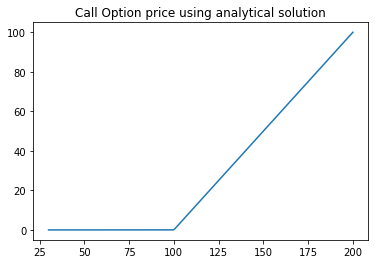

In [52]:
Ss = np.linspace(Smin, Smax, ns, endpoint=True)
fs = f(0, Ss)
plt.plot(Ss,fs)
plt.title("Call Option price using analytical solution")

Text(0.5, 1.0, 'FDM explicit method with nt=4555')

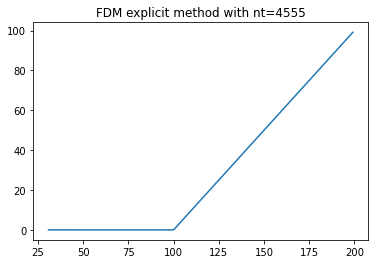

In [28]:
sigma = 0.25
miu = 0.02
K = 100
ns = 201
Smin = 30
Smax = 200
T = 1

n = ns-2
m = 4555
X = np.linspace(Smin, Smax, n+2)
X = X[1:-1]

payoff = np.clip(X-K, 0.0, 1e50)
   
Fl = np.zeros((m+1,))
Fu = Smax + miu*(T-np.linspace(0.0, T, m+1)) - K

bm_ex = Q_explicit(mu, sigma, T, Smin, Smax, Fl, Fu, payoff, m, n)
sol_ex = bm_ex.solve()
nrow = len(sol_ex[:,1])
plt.plot(X, sol_ex[nrow-1,:])
plt.title(f'FDM explicit method with nt={m}')

5. [20 points]
Adapt the code from the lecture to compute $f(0,s)$ for $S \in [30, 200]$ using the implicit scheme and compare with the analytical expression of $u(t,s)$ and from the fact that $u(t,s) = f(t,se^{-at})e^{-bt}$. Explain how you choose the number of steps in the time and space dimension.

In [48]:
class Q_implicit:
    def __init__(self, 
               miu, 
               sigma, 
               maturity, 
               Smin, 
               Smax, 
               Fl, 
               Fu, 
               payoff, 
               nt, 
               ns):
        self.miu  = miu 
        self.sigma = sigma 
        self.maturity  = maturity

        self.Smin = Smin     
        self.Smax = Smax
        self.Fl = Fl        
        self.Fu = Fu

        self.nt  = nt
        self.ns  = ns

        self.dt = float(maturity)/nt
        self.dx = float(Smax-Smin)/(ns+1)
        self.xs = Smin/self.dx

        self.u = np.empty((nt + 1, ns))
        self.u[0,:] = payoff

        ## Building Coefficient matrix:        
        A = sparse.lil_matrix((self.ns, self.ns))

        for j in range(0, self.ns):

            dtmp1 = .5* self.miu* (self.dt/ self.dx)
            dtmp2 = self.dt* (self.sigma/ self.dx)**2

            A[j,j] = 1.0 - dtmp2
            if j > 0:
                A[j,j-1] = - dtmp1 + dtmp2/2
            if j < self.ns - 1:
                A[j,j+1] =   dtmp1 + dtmp2/2

        self.A = linsolve.splu(A)
        self.rhs = np.empty((self.ns, ))

        ### Building bc_coef:
        cf1 = .5* self.miu* (self.dt/ self.dx)
        cf2 = self.dt* (self.sigma/ self.dx)**2

        self.blcoef = - cf1 + .5*cf2
        self.bucoef =   cf1 + .5*cf2
    
    def solve(self):
        for i in range(0, self.nt):
            self.rhs[:] = self.u[i,:]
            self.rhs[0]         -= self.blcoef * self.Fl[i]
            self.rhs[self.ns-1] -= self.bucoef * self.Fu[i]
            self.u[i+1,:] = self.A.solve(self.rhs)

        return self.u

/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Text(0.5, 1.0, 'FDM implicit method with nt=200')

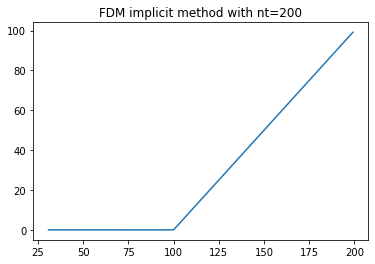

In [51]:
m = 3000
Fl = np.zeros((m+1,))
Fu = Smax + miu*(T-np.linspace(0.0, T, m+1)) - K

bm_im = Q_implicit(miu, sigma, T, Smin, Smax, Fl, Fu, payoff, m, n)
sol_im = bm_im.solve()
nrow = len(sol_im[:,1])
plt.plot(X, sol_im[nrow-1,:])
plt.title(f'FDM implicit method with nt={m}')

The implicit method is unconditionally stable, so we can choose steps in concern of both accuracy and excuting time.